# SaaS Customer Churn Prediction and Renewal Analysis
- The goal of this project is underdstand customer churn patterns and predict renewals for a SaaS company using historical data.
- The below is simulating the customer info from SaaS Company A

In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer, TargetEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Customer Data - Simulating data from a CRM system, this is 5000 sample of customers WW
- Customer ID: Unique ID given to customer in CRM

- Customer Size: Number of active full time employees that we use for licensing

- Annual Revenue: The latest reported revenue the customer reported based on sales intelligence softwate in the CRM 

- Industry: Customer industry

- C-Level Engagment: In B2B sales, how engaged we are to high level executives to get buy in for renewing contracts is critical, this is measuring how engaged they are from 'low' < 'medium' < 'high' based on email and meeting activity on the CRM

- Open Deals: Number of open opportunities tied to the customer account in the CRM

- Customer Sign Up Date: The day the customer officualy signed their contract

- Amount ARR Cloud: Annual Reoccuring Revenue coming from the customer payment for our SaaS service 

- Amount ARR On Prem: Annual Reoccuring Revenue coming from the customer payment for our on premises services

- Feature 1 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 1

- Feature 2 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 2

- Feature 3 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 3

- Churned: '0' indicates the customer is still active, '1' did not renew their contract

- Next Renewal Data: The date the contract expires

- Last QBR Date: The last date the account team held a Quaterly Business Review witht the customer executives

- Amount ARR Total: Sum of ARR Cloud and ARR On premises, total customer spend

- Customer Age: Number of Months the account has been an active customer

- Days between Renewal and QBR: Number of days between the last QBR date and the date the contract expires 

In [39]:
df_customers = pd.read_csv('exported_customer_data.csv')
df_customers.head()

,customer_id,customer_size,annual_revenue,industry,c_level_engagement,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,feature_1_usage,feature_2_usage,feature_3_usage,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age,days_between_renewal_and_qbr,churned
0,1,1475,804596.82,Finance,medium,1,2014-03-07,119194.17,8167.70,medium,high,low,2017-03-07,2015-07-08,127361.87,142,608,0
1,2,1552,871342.57,Healthcare,medium,0,2020-09-07,91621.09,10043.98,medium,high,high,2023-09-07,2023-04-24,101665.07,63,136,0
2,3,1773,1043744.66,Retail,medium,0,2016-08-26,278745.96,5539.81,high,high,high,2019-08-26,2017-05-15,284285.77,112,833,0
3,4,1518,992437.78,Healthcare,medium,1,2020-09-04,195754.58,7356.65,high,high,high,2023-09-04,2020-11-11,203111.23,63,1027,0
4,5,1931,1238123.57,Healthcare,high,0,2015-05-28,188470.47,6479.03,low,high,high,2018-05-28,2018-02-14,194949.50,128,103,0


# EDA
- Before builing a model, anaylizing the dataset above for nulls, duplicates, data cleaning, understading distribuions, and relationships among features

In [40]:
# Quick glance at number of nulls and data types
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   6000 non-null   int64  
 1   customer_size                 6000 non-null   int64  
 2   annual_revenue                6000 non-null   float64
 3   industry                      6000 non-null   object 
 4   c_level_engagement            6000 non-null   object 
 5   open_deals                    6000 non-null   int64  
 6   customer_sign_up_date         6000 non-null   object 
 7   amount_ARR_cloud              6000 non-null   float64
 8   amount_ARR_on_prem            6000 non-null   float64
 9   feature_1_usage               6000 non-null   object 
 10  feature_2_usage               6000 non-null   object 
 11  feature_3_usage               6000 non-null   object 
 12  next_renewal_date             6000 non-null   object 
 13  las

In [41]:
df_customers['customer_sign_up_date'] = pd.to_datetime(df_customers['customer_sign_up_date'])
df_customers['next_renewal_date'] = pd.to_datetime(df_customers['next_renewal_date'])
df_customers['last_qbr_date'] = pd.to_datetime(df_customers['last_qbr_date'])

# Summary statistics of numerical features
df_customers.describe()

,customer_id,customer_size,annual_revenue,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age,days_between_renewal_and_qbr,churned
count,6000.000000,6000.000000,6.000000e+03,6000.000000,6000,6.000000e+03,6000.000000,6000,6000,6.000000e+03,6000.000000,6000.000000,6000.000000
mean,3000.500000,1499.603167,9.953125e+05,0.203500,2016-07-01 02:15:07.199999744,1.871399e+05,8464.284057,2019-07-01 20:39:21.600000256,2018-01-02 20:08:24,1.956042e+05,114.215833,545.021500,0.367167
min,1.000000,547.000000,2.917928e+05,0.000000,2010-01-01 00:00:00,1.976753e+04,2271.330000,2013-01-01 00:00:00,2010-01-19 00:00:00,2.964015e+04,35.000000,0.000000,0.000000
25%,1500.750000,1331.000000,8.587148e+05,0.000000,2013-04-01 18:00:00,1.138022e+05,6624.830000,2016-04-01 18:00:00,2014-10-06 00:00:00,1.222665e+05,75.000000,268.000000,0.000000
50%,3000.500000,1502.000000,9.949988e+05,0.000000,2016-07-11 12:00:00,1.639034e+05,8117.695000,2019-07-11 12:00:00,2017-12-28 12:00:00,1.723308e+05,114.000000,543.000000,0.000000
75%,4500.250000,1666.000000,1.129944e+06,0.000000,2019-09-11 00:00:00,2.327114e+05,9937.310000,2022-09-11 00:00:00,2021-04-06 06:00:00,2.410730e+05,154.000000,820.000000,1.000000
max,6000.000000,2291.000000,1.692779e+06,1.000000,2022-12-29 00:00:00,1.548727e+06,37258.080000,2025-12-29 00:00:00,2025-12-26 00:00:00,1.554255e+06,193.000000,1096.000000,1.000000
std,1732.195139,247.665113,1.996175e+05,0.402635,NaN,1.078670e+05,2609.428851,NaN,NaN,1.078875e+05,45.538755,318.647332,0.482073


In [42]:
# Checking for duplicate entries
df_customers.duplicated().sum()

0

In [43]:
# Identifying and Partitioning feature types in the DataFrame
feature_use = [['low', 'medium', 'high']] * len(categorical_features)


# Numeric columns (int, float, nullable types)
numeric_features = df_customers.select_dtypes(include=['int64', 'float64','int32']).columns.to_list()
numeric_features.remove('churned')  
numeric_features.remove('customer_id')
# Categorical columns that are explicitly dtype "category"
categorical_features = ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']


# Nominal (object) features — typical object columns
nominal_categorical_features = ['industry']

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Nominal categorical features:", nominal_categorical_features)

Numeric features: ['customer_size', 'annual_revenue', 'open_deals', 'amount_ARR_cloud', 'amount_ARR_on_prem', 'amount_ARR_total', 'customer_age', 'days_between_renewal_and_qbr']
Categorical features: ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']
Nominal categorical features: ['industry']


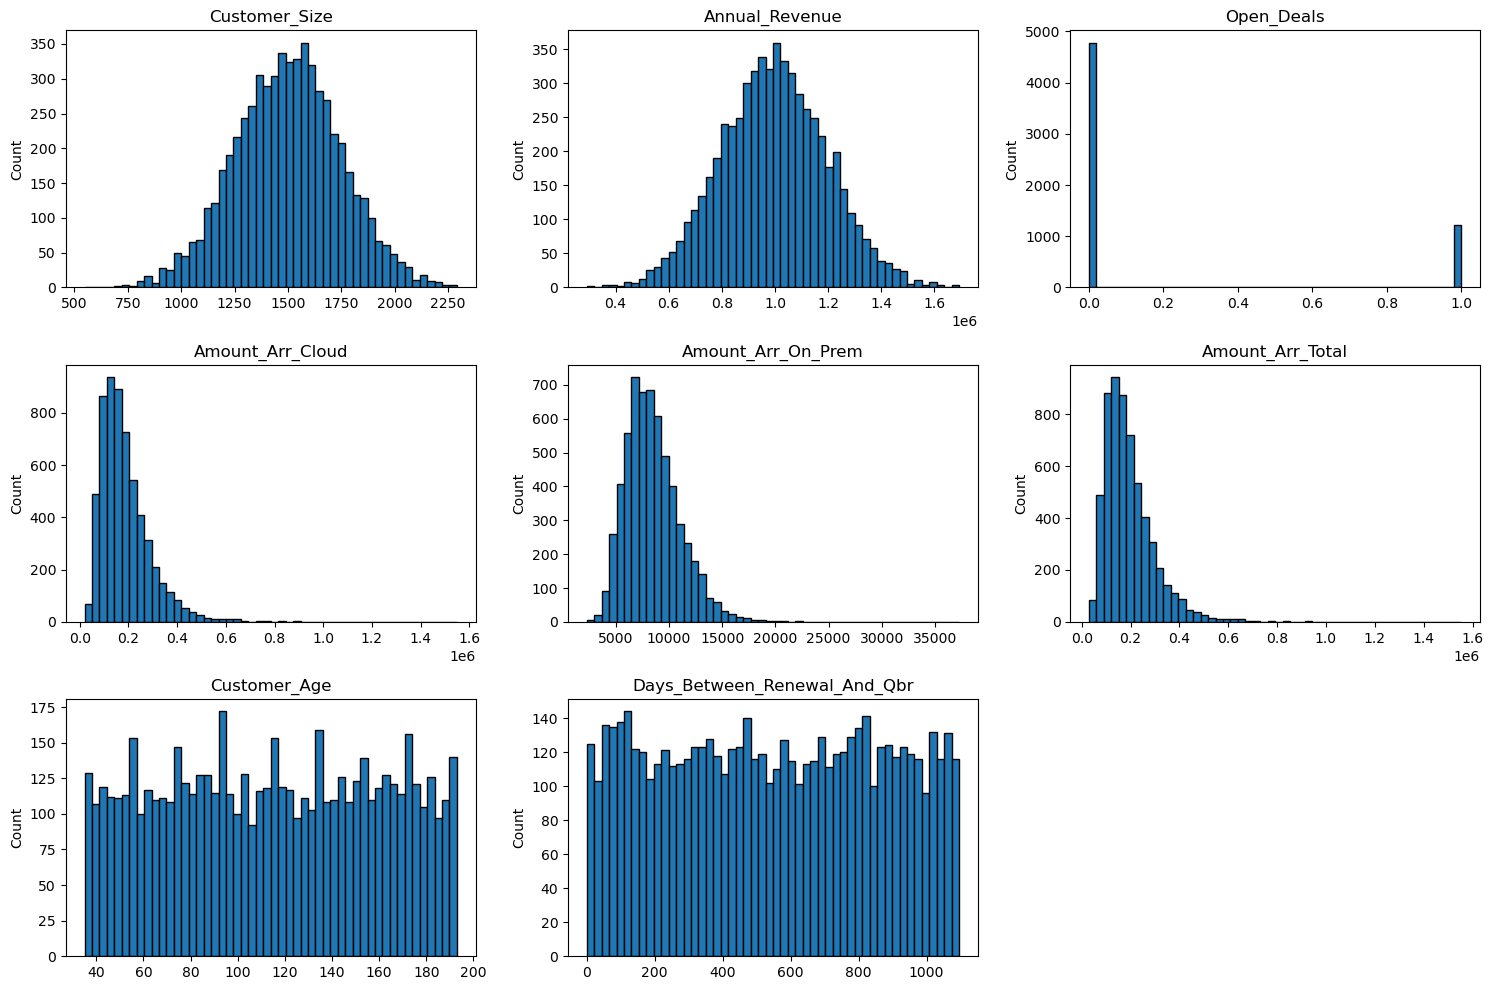

In [44]:
# Visualizing distributions of numerical features

ax = df_customers[numeric_features].hist(figsize=(15, 10), bins=50, edgecolor='black', grid=False)

# Make titles cleaner + adjust layout
for row in ax:
    for subplot in row:
        subplot.set_title(subplot.get_title().title())
        subplot.set_xlabel(subplot.get_xlabel().replace('_', ' ').title())
        subplot.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Key takeaways:
- Annual Revenue is normally distributed
- ARR features have a right skew, important to transform these features prior to model fitting

Text(0.5, 1.0, 'Correlation Matrix for Numeric Features')

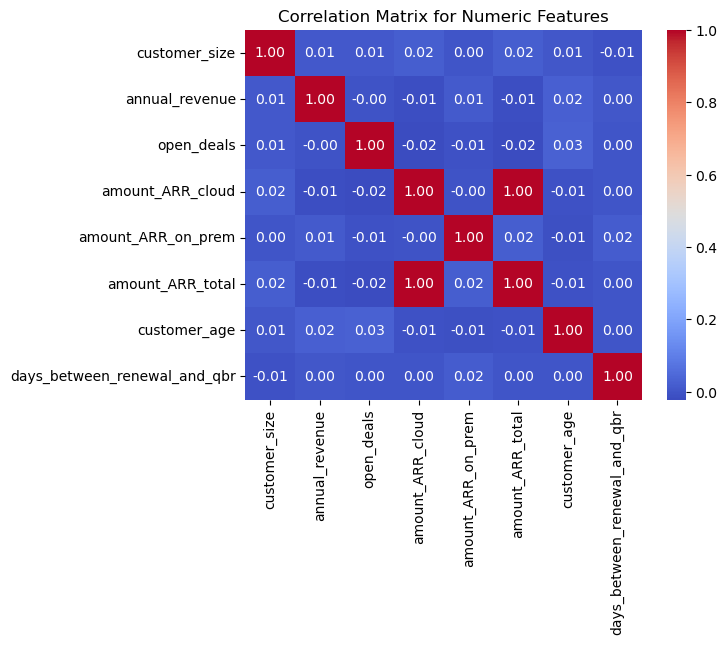

In [45]:
#  Correlation matrix for numeric features
df_customers[numeric_features].corr()
sns.heatmap(df_customers[numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')

# Key Take Aways
- Since ARR total depends of two other features, we do not need it as part of model fitting
- No other pair of features are highly correlated

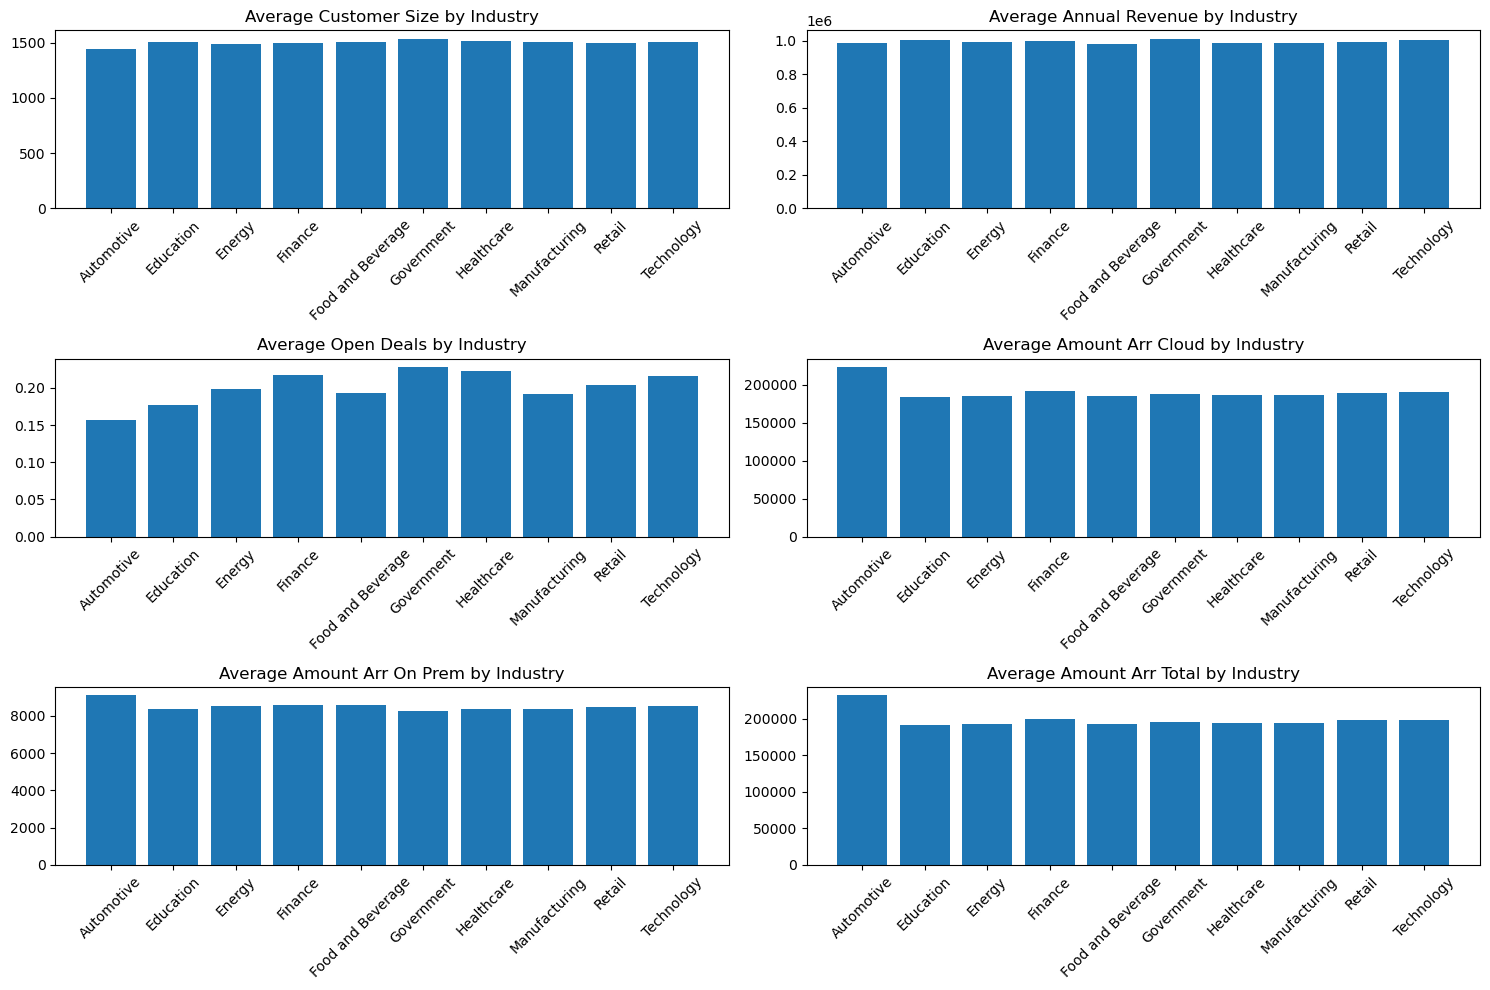

In [46]:
# Average numerical feature values by industry
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

all_axes = ax.flatten()

for num_feat, subplot in zip(numeric_features, all_axes):

    industry_group = df_customers.groupby('industry')[num_feat].mean()

    subplot.bar(x=industry_group.index, height=industry_group.values)
    
    subplot.set_title(f'Average {num_feat.replace("_", " ").title()} by Industry')
    subplot.tick_params(axis='x', rotation=45) # Rotate X-labels
    plt.tight_layout()

In [47]:
# Churn rate by industry
pd.crosstab(df_customers['industry'], df_customers['churned'], normalize='index')

churned,0,1
industry,,
Automotive,0.781250,0.218750
Education,0.620042,0.379958
Energy,0.633513,0.366487
Finance,0.638393,0.361607
Food and Beverage,0.625912,0.374088
Government,0.617761,0.382239
Healthcare,0.611227,0.388773
Manufacturing,0.587432,0.412568
Retail,0.667343,0.332657


In [48]:
# Looking at churn rates for the the sample
df_customers['churned'].value_counts(normalize=True)

churned
0    0.632833
1    0.367167
Name: proportion, dtype: float64

# Preprocessing + Feature Engineering
- Before creating and fitting the model, we are going to preprocess and perform feature engineering
- First we will remoce Amount ARR total since it is not an independent feature
- Will define our features (X) and our target variable (y)
- Since our ARR feature have a right skew, we use Power Transformer (take the log of numbers) to ensure we have a normal distribution
- Then we will map the appropiate processing to each data type
- Numerical features will be transformed by Standard Scaler to ensure they have center and std
- Nominal features will be transformed by OneHotEncoding 
- Categorical features will be transfomed by OrdinalEncoder to preserve ranking
- We will remove any features with low variance
- Lastly, we split our data to traning and testing splits/


In [49]:
#Remove highly correlated feature
numeric_features.remove('amount_ARR_total')

# Combining all feature types for modeling
features = list(numeric_features) + list(categorical_features) + list(nominal_categorical_features)

# Define feature matrix X and target variable y
X = df_customers[features]
y = df_customers['churned']

# Dealing with class imbalance using RandomUnderSampler
#rus = RandomUnderSampler()
#X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Defining preprocessing steps with ColumnTransformer
power_features = ['amount_ARR_cloud','amount_ARR_on_prem']
num_remaining = [feature for feature in numeric_features if feature not in power_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('power', Pipeline([('power', PowerTransformer()), ('scale', StandardScaler())]), power_features),
        ('num_scale', StandardScaler(), num_remaining),
        ('cat_ord', OrdinalEncoder(categories=feature_use), categorical_features),
        ('nom_ohe', OneHotEncoder(drop='first',handle_unknown='ignore'), nominal_categorical_features)
    ])


# Building + Evaluating the Model
- We will use a Logistic Regression model, and we will search for the ideal hyperparameters using Randomized Search.

- We will test for both L1 and L2 regression and how strong the regularization should be by C

In [51]:
# Hyperparameters Tuning to optimize Logistic Regression model

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

params = {
    'penalty': ['l1', 'l2'], # Now includes the mixed penalty
    'C': np.logspace(-4, 4, 50)        # Denser log search for C# The mixing parameter for Elastic Net
}

log_classifier = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=2000)

log_classifier_tuned = GridSearchCV(estimator=log_classifier, param_grid=params, cv=10, scoring='recall')


In [52]:
log_classifier_tuned.fit(X_train_transformed, y_train)

log_classifier_tuned.best_params_

{'C': 0.0013894954943731374, 'penalty': 'l1'}

In [53]:
# Evaluate the best model on the test set
best_model = log_classifier_tuned.best_estimator_

In [54]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))

    # Plot the matrix
    disp.plot(cmap=plt.cm.Blues) # cmap sets the color scheme (e.g., 'viridis', 'Reds')
    plt.title("Confusion Matrix")
    plt.show()

    roc_curves = roc_curve(y_test, best_model.predict_proba(X_test_transformed)[:, 1])
    plt.plot(roc_curves[0], roc_curves[1], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    print("ROC AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test_transformed)[:, 1]))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75       752
           1       0.59      0.78      0.67       448

    accuracy                           0.72      1200
   macro avg       0.72      0.73      0.71      1200
weighted avg       0.75      0.72      0.72      1200



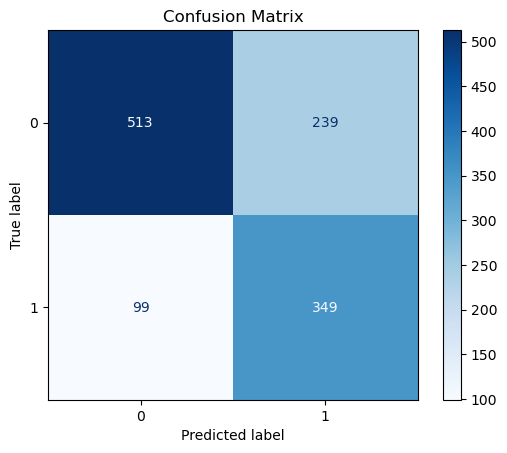

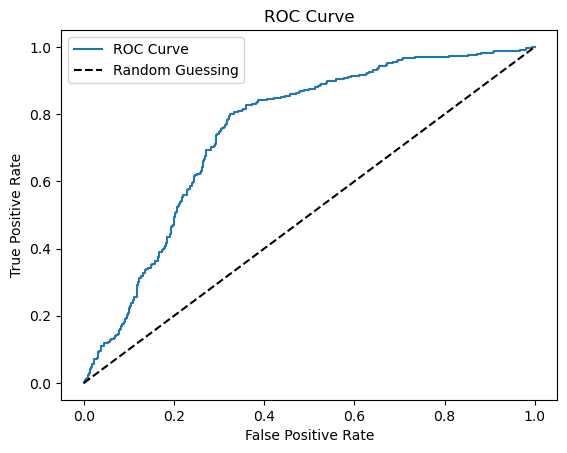

ROC AUC Score: 0.7507598784194528


In [55]:
evaluate_model(best_model, X_test_transformed, y_test)